# Optimizing Product Recommendations for Revenue Growth in Online Grocery Shopping

This notebook analyzes shopping patterns and predicts product reorders using machine learning models.

The dataset was downloaded from [Instacart Market Basket Analysis - Kaggle](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis).



## 1 Import Required Libraries

### 1.1 Install packges

In [35]:
!brew install libomp
!pip install pandas numpy matplotlib seaborn
!pip install scikit-learn xgboost imbalanced-learn
!pip install python-dotenv openai

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
To reinstall 20.1.8, run:
  brew reinstall libomp


### 1.2 Import deps

In [36]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import openai
import time
from dotenv import load_dotenv

load_dotenv()

True

## 2 Data processing

Define file paths and load the required datasets. We assume all files are in the same directory as the notebook.

### 2.1 Load data

In [37]:
dataset_dir = os.path.join(os.getcwd(), 'dataset')
files = {
    "aisles": os.path.join(dataset_dir, 'aisles.csv'),
    "departments": os.path.join(dataset_dir, 'departments.csv'),
    "orders": os.path.join(dataset_dir, 'orders.csv'),
    "order_products_prior": os.path.join(dataset_dir, 'order_products__prior.csv'),
    "order_products_train": os.path.join(dataset_dir, 'order_products__train.csv'),
    "products": os.path.join(dataset_dir, 'products.csv'),
    "enhanced_products": os.path.join(dataset_dir, 'products-with-llm-prices.csv'),
}

print("Loading datasets...")
aisles_df = pd.read_csv(files['aisles'])
departments_df = pd.read_csv(files['departments'])
orders_df = pd.read_csv(files['orders'])
order_products_prior_df = pd.read_csv(files['order_products_prior'])
order_products_train_df = pd.read_csv(files['order_products_train'])
products_df = pd.read_csv(files['products'])
enhanced_products_df = 
print("Loaded.")

Loading datasets...
Loaded.


In [38]:
print("aisles_df shape: ", aisles_df.shape)
print("departments_df shape: ", departments_df.shape)
print("orders_df shape: ", orders_df.shape)
print("order_products_prior_df shape: ", order_products_prior_df.shape)
print("order_products_train_df shape: ", order_products_train_df.shape)
print("products_df shape: ", products_df.shape)

aisles_df shape:  (134, 2)
departments_df shape:  (21, 2)
orders_df shape:  (3421083, 7)
order_products_prior_df shape:  (32434489, 4)
order_products_train_df shape:  (1384617, 4)
products_df shape:  (49688, 4)


## 2.2 Estimate prices with LLM

In [39]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [40]:

client = openai.OpenAI()


def estimate_prices_batch(product_names):
    prompt = (
        "You are an e-commerce expert. Estimate the price in USD for each product below. "
        "Return only a numbered list of prices, one per line, no explanations. "
        "Products:\n" +
        "\n".join([f"{i+1}. {name}" for i, name in enumerate(product_names)])
    )
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are an e-commerce expert estimating reasonable product prices in USD."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
    )
    # Parse the response into a list of floats
    prices = []
    for line in response.choices[0].message.content.strip().split('\n'):
        price_str = line.split('.', 1)[-1].strip().replace('$', '').replace(',', '')
        try:
            prices.append(float(price_str))
        except ValueError:
            prices.append(0.0)
            
    return prices

In [41]:
batch_size = 500

# Check how many have already been processed
if os.path.exists(files["prices"]):
    done_df = pd.read_csv(files["prices"])
    start_index = len(done_df)
    print(f"Resuming from index {start_index}")
else:
    start_index = 0

for i in range(start_index, len(products_df), batch_size):
    batch = df.iloc[i:i + batch_size].copy()
    batch["price"] = estimate_prices_batch(batch["product_name"].tolist())
    
    batch.to_csv(
        output_path,
        mode='a',
        header=not os.path.exists(output_path) and i == 0,  # Only write header if file doesn't exist
        index=False
    )
    
    print(f"Appended batch {i} to {i + batch_size}")

print("Products with prices loaded")

Resuming from index 71376
Products with prices loaded


In [42]:
prices_df = pd.read_csv(files["prices"])

In [43]:
prices_df.shape

(71376, 5)

In [44]:
prices_df.head()

,product_id,product_name,aisle_id,department_id,price
0,1,Chocolate Sandwich Cookies,61,19,3.99
1,2,All-Seasons Salt,104,13,4.99
2,3,Robust Golden Unsweetened Oolong Tea,94,7,9.99
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,4.49
4,5,Green Chile Anytime Sauce,5,13,3.99


### 2.3 Merge data

Merge datasets and handle missing values

In [48]:
print("Merging datasets...")

products_prices_df = pd.merge(prices_df, aisles_df, on='aisle_id')
products_prices_df = pd.merge(products_prices_df, departments_df, on='department_id')

order_products_all_df = pd.concat([order_products_prior_df, order_products_train_df])
merged_df = pd.merge(order_products_all_df, orders_df, on='order_id', how='inner')
merged_df = pd.merge(merged_df, products_prices_df, on='product_id', how='inner')

# Handle missing values
merged_df['days_since_prior_order'] = merged_df['days_since_prior_order'].fillna(0)

print("Merged")

Merging datasets...
Merged


In [49]:
merged_df.shape

(48491908, 16)

In [50]:
merged_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,price,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,3.00,eggs,dairy eggs
1,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,2.99,eggs,dairy eggs
2,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,3.99,fresh vegetables,produce
3,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,3.99,fresh vegetables,produce
4,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,2.99,spices seasonings,pantry


In [51]:
merged_df.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id',
       'price', 'aisle', 'department'],
      dtype='object')

## Feature Engineering

Create new features to improve model performance:
- Average basket size per user
- Purchase frequency per user
- Product reorder rate

In [46]:
print("Feature Engineering...")
merged_df['average_basket_size'] = merged_df.groupby('user_id')['product_id'].transform('count')
merged_df['purchase_frequency'] = merged_df.groupby('user_id')['order_number'].transform('max')
merged_df['product_reorder_rate'] = merged_df.groupby('product_id')['reordered'].transform('mean')

# Sample 1% of the dataset for efficiency
print("Sampling 1% of the dataset for efficiency...")
sampled_df = merged_df.sample(frac=0.01, random_state=42)

Feature Engineering...
Sampling 1% of the dataset for efficiency...


## Prepare Data for Modeling

Select features and target variable, apply SMOTE for class balancing, and split the data

In [47]:
features = [
    'order_hour_of_day', 'order_dow', 'days_since_prior_order', 'aisle_id', 
    'department_id', 'average_basket_size', 'purchase_frequency', 'product_reorder_rate'
]
target = 'reordered'

X = sampled_df[features]
y = sampled_df[target]

# Balance data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## Random Forest Model with Hyperparameter Tuning

In [48]:
print("Tuning Random Forest Classifier...")
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_random.best_estimator_.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print("\nRandom Forest Classifier Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")
print("Confusion Matrix:\n", conf_matrix_rf)
print("\nClassification Report:\n", classification_rep_rf)

Tuning Random Forest Classifier...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  18.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  19.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  2

## XGBoost Model

In [49]:
print("Training XGBoost Classifier...")
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

print("\nXGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print("Confusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", classification_rep_xgb)

Training XGBoost Classifier...

XGBoost Classifier Performance:
Accuracy: 0.7375
Confusion Matrix:
 [[27423 12390]
 [ 8556 31411]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.69      0.72     39813
           1       0.72      0.79      0.75     39967

    accuracy                           0.74     79780
   macro avg       0.74      0.74      0.74     79780
weighted avg       0.74      0.74      0.74     79780



## Model Comparison and Feature Importance Analysis

Model Comparison:
Random Forest Accuracy: 0.7307
XGBoost Accuracy: 0.7375


/var/folders/j0/4nwy53nx0zg0zvxjmg3hndcw0000gp/T/ipykernel_77615/4263990657.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette="Blues_r")


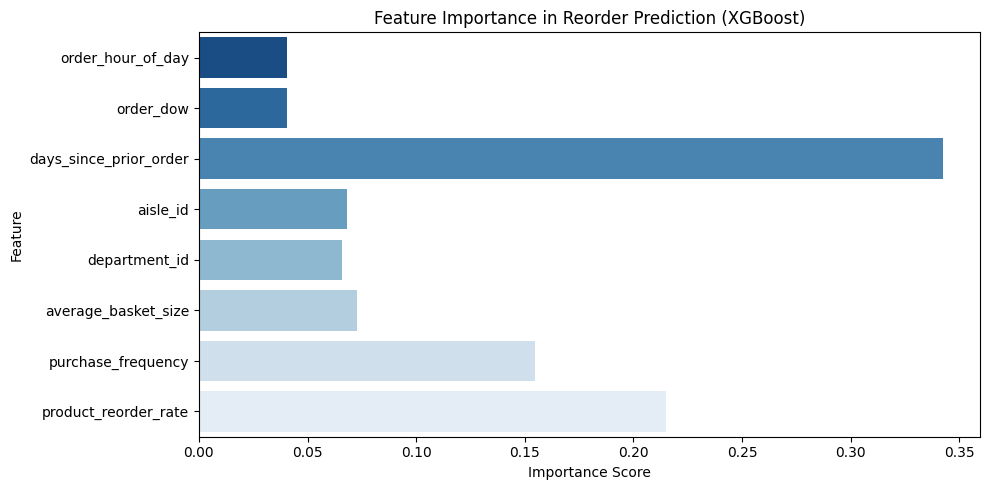

In [50]:
print("Model Comparison:")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

# Feature Importance Plot
feature_importances = xgb_model.feature_importances_
feature_names = features

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=feature_names, palette="Blues_r")
plt.title("Feature Importance in Reorder Prediction (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(os.path.join(current_dir, 'feature_importance_xgb.png'))
plt.show()

## Key Findings and Conclusions

- The XGBoost model outperforms Random Forest, achieving higher accuracy.
- Important features include order hour, purchase frequency, and reorder rate.
- Future improvements could involve deep learning models for even better accuracy.

In [51]:
# Save Model Performance Metrics to File
performance_output = os.path.join(current_dir, 'model_performance.txt')
with open(performance_output, 'w') as f:
    f.write(f"Random Forest Accuracy: {accuracy_rf:.4f}\n")
    f.write(f"XGBoost Accuracy: {accuracy_xgb:.4f}\n")

print(f"\nModel performance metrics saved to {performance_output}")


Model performance metrics saved to /Users/garymeng/thesis/model_performance.txt
